In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz as gr
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math

### Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates. 

In this setting, I assume that the treatment has been assigned randomly. For each unit in the sample, we observe the outcome $Ti$, the value of the treatment $Ti$ and possibly the values of covariates $Xi$. The sample size is $n$.

The treatment $T_i$ is a dummy variable.

$
T_i=\begin{cases}
1 \ , \text{if unit i received the treatment}\\
0 \ , \text{otherwise}\\
\end{cases}
$

All observations are assigned treatment with the same probability p0:

$Ti \sim Bernoulli(p)$

For the case a (do not control for any covariates): 

$Y_i = \alpha + \tau * T_i + e_i$

For the case b (control for all the covariates that affect the outcome): 

$Y_i = \alpha + \tau * T_i + g(X_1i) + u(X_2i) + v(X_3i) + e_i$

where $e_i \sim N(0,\sigma^2)$, this is the error term with expected value 0, and $g(·)$ is a function which means X may be unlinear with Y, and $\tau$ represents the treatment effect.

For the treatment effect, I assume a case of a constant effect here, which means that the treatment is the same for each individual, thus, $\tau$ is equal to a constant c. 

I use following settings:

$\alpha = 0.5$ 

$g(X_1) = \beta_1 * X_1 = -0.2X_1$

$u(X_2) = \beta_2 * X_2 = -0.3X_2$

$v(X_3) = \beta_3 * X_3 = 0.1X_3$

$p = 0.5$

$\tau = 0.35$

#### Simulate a DGP

In [2]:
a = 0.5
b1 = -0.2
b2 = -0.3
b3 = 0.1
#probability
p = 0.5
#treatment effect
tau = 0.35
#sample size
n = 100

#covariates
X1 = np.random.uniform(0, 100, n)
X2 = np.random.uniform(0, 100, n)
X3 = np.random.uniform(0, 50, n)
#treatment
T = np.random.binomial(1, p, n)
#noise
e = np.random.normal(0,0.25,n)
#dependent variable
Y = a + tau*T - 2.5*X1 -3*X2 + 3.5*X3 + e

#### DAG

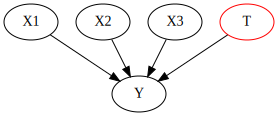

In [3]:
g = gr.Digraph()
g.edge("X1", "Y"), g.edge("X2", "Y"), g.edge("X3", "Y"), g.edge("T", "Y")
g.node("T", color = "red")
g

#### Monte Carlo experiment with sample sizes N=100 and N=1000

In [4]:
class MCsimulator_1a():
    
    def __init__(self,n_rep):
        
        self.n_rep = n_rep
        
    def simulate_data(self, a, t, n):
        
        T = np.random.binomial(1, 0.5, n)
        e = np.random.normal(0,0.25,n)
        Y = a + t*T + e
        
        return (Y,T)
    
    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,t,n):

        t_estimates = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(a,t,n)
            a_hat, t_hat = self.estimate_ols_params(Y,T)
            t_estimates = t_estimates + [t_hat]
        return t_estimates
    
    def summarize_mc_simulation(self,a,t,n):
        t_estimates = self.run_mc_simulation(a,t,n)
        MSE = np.square(np.subtract(t,t_estimates)).mean() 
        RMSE = math.sqrt(MSE)
        print(f'Mean of treatment effect estimates = {np.mean(t_estimates):.3f} \n')
        print(f'Bias = {np.mean(t_estimates)-0.35:.3f} \n')
        print(f'Root Mean Square Error = {RMSE:.3f} \n')
        


In [5]:
mcSim_1a = MCsimulator_1a(100)
mcSim_1a.summarize_mc_simulation(0.5,0.35,100)

Mean of treatment effect estimates = 0.350 

Bias = 0.000 

Root Mean Square Error = 0.050 



In [6]:
mcSim_1a = MCsimulator_1a(1000)
mcSim_1a.summarize_mc_simulation(0.5,0.35,1000)

Mean of treatment effect estimates = 0.350 

Bias = 0.000 

Root Mean Square Error = 0.015 



In [7]:
class MCsimulator_1b():
    
    def __init__(self,n_rep):
        
        self.n_rep = n_rep
        
    def simulate_data(self,a,t,b1,b2,b3,n):
        
        X1 = np.random.uniform(0, 100, n)
        X2 = np.random.uniform(0, 100, n)
        X3 = np.random.uniform(0, 50, n)
        T = np.random.binomial(1, 0.5, n)
        e = np.random.normal(0,0.25,n)
        Y = a + t*T + b1*X1 + b2*X2 + b3*X1 + e
        df = pd.DataFrame(dict(Y=Y,T=T,X1=X1,X2=X2,X3=X3))
        
        return df
    
    def estimate_ols_params(self,df):
        exog = df[['T','X1','X2','X3']]
        mod = sm.OLS(df['Y'],sm.add_constant(exog))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,t,b1,b2,b3,n):
        
        t_estimates = []
        for rep in range(self.n_rep):
            df = self.simulate_data(a,t,b1,b2,b3,n)
            a_hat,t_hat,b1_hat,b2_hat,b3_hat = self.estimate_ols_params(df)
            t_estimates = t_estimates + [t_hat]
            
        return t_estimates
    
    def summarize_mc_simulation(self,a,t,b1,b2,b3,n):
        
        t_estimates = self.run_mc_simulation(a,t,b1,b2,b3,n)
        MSE = np.square(np.subtract(t,t_estimates)).mean() 
        RMSE = math.sqrt(MSE)
        print(f'Mean of the treatment estimates = {np.mean(t_estimates):.3f} \n')
        print(f'Bias = {np.mean(t_estimates)-0.35:.3f} \n')
        print(f'Root Mean Square Error = {RMSE:.3f} \n')
        

In [8]:
mcSim_1b = MCsimulator_1b(100)
mcSim_1b.summarize_mc_simulation(0.5,0.35,-0.2,-0.3,0.1,100)

/Users/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Mean of the treatment estimates = 0.343 

Bias = -0.007 

Root Mean Square Error = 0.051 



In [9]:
mcSim_1b = MCsimulator_1b(1000)
mcSim_1b.summarize_mc_simulation(0.5,0.35,-0.2,-0.3,0.1,1000)

Mean of the treatment estimates = 0.350 

Bias = -0.000 

Root Mean Square Error = 0.016 



#### An example of a real-life situation

An example of a real-life situation that might be consistent with this DGP could be an experiment on cardiovascular disease. Obesity and overweight are the main risk factors of cardiovascular disease, for example, atherosclerotic cardiovascular disease(ASCVD). In order to study the effect of weight loss on the risk of ASCVD, overweight people were divided into two groups. The standard of body weight is measured by body mass index (BMI). The intervention group will be instructed to maintain appropriate physical exercise and diet to achieve the purpose of weight loss, so this is the treatment. The covariates that can be collected include the frequency of smoking, the frequency of drinking alcohol and the level of mental health. A ASCVD risk indicator will used as the outcome.

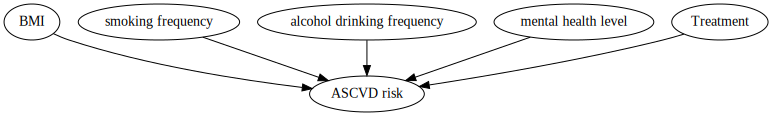

In [10]:
g = gr.Digraph()
g.edge("BMI", "ASCVD risk")
g.edge("smoking frequency", "ASCVD risk"), 
g.edge("alcohol drinking frequency", "ASCVD risk"), 
g.edge("mental health level", "ASCVD risk"), 
g.edge("Treatment", "ASCVD risk")
g.node("Treatment")
g

### Simulate a DGP with a confounder

#### An example of a real-life situation

The example I want to use is to study the effect of weekly exercise time on cholesterol. One problem that must be considered is that the average cholesterol level is different among people of different ages. So in this experiment, age is a categorical doubt.

The unit of weekly total exercise time is minutes per week, and the standard range of measure of cholesterol is around 2 to 6 mmol/L. 

#### Simulate a DGP

In [11]:
#sample size
n = 100

ages = np.random.gamma(8,4,n).astype(int)
cholesterol = np.random.beta(5, 2, n) * (0.15*ages)
exercise = abs(np.random.normal(100,100,n) * (0.05*ages)).astype(int)

df = pd.DataFrame(dict(age = ages,
                      cholesterol = cholesterol,
                      exercise = exercise))

mod = smf.ols('cholesterol ~ exercise + age', data=df)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cholesterol   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     87.27
Date:                Fri, 15 Apr 2022   Prob (F-statistic):           2.08e-22
Time:                        10:58:03   Log-Likelihood:                -132.21
No. Observations:                 100   AIC:                             270.4
Df Residuals:                      97   BIC:                             278.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1813      0.259      0.701      0.485      -0.332       0.695
exercise      -0.0014      0.001     -2.200      0.030      -0.003      -0.000
age            0.1090      0.009     12.605      0.000       0.092       0.126
==============================================================================
Omnibus:                       11.401   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               19.244
Skew:                          -0.449   Prob(JB):                     6.62e-05
Kurtosis:                       4.952   Cond. No.                         675.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### DAG

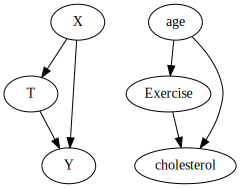

In [12]:
g = gr.Digraph()
g.edge("X", "T")
g.edge("X", "Y")
g.edge("T", "Y")

g.edge("age", "Exercise")
g.edge("age", "cholesterol")
g.edge("Exercise", "cholesterol")
g

#### Monte Carlo experiment with sample sizes N=100 and N=1000

In [13]:
class MCsimulator_2a():
    
    def __init__(self,n_rep):
        
        self.n_rep = n_rep
        
    def simulate_data(self,t,n):
        
        ages = np.random.gamma(8,4,n).astype(int)
        cholesterol = np.random.beta(5, 2, n) * (0.15*ages)
        exercise = abs(np.random.normal(100,100,n) * (0.05*ages)).astype(int)
        df = pd.DataFrame(dict(age = ages,
                              cholesterol = cholesterol,
                              exercise = exercise))
        
        return df
    
    def estimate_ols_params(self,df):
        
        mod = smf.ols('cholesterol ~ exercise', data=df)
        res = mod.fit()

        return res.params
    
    def run_mc_simulation(self,t,n):

        t_estimates = []
        for rep in range(self.n_rep):
            mod = self.simulate_data(t,n)
            a_hat, t_hat = self.estimate_ols_params(df)
            t_estimates = t_estimates + [t_hat]
        return t_estimates
    
    def summarize_mc_simulation(self,t,n):
        t_estimates = self.run_mc_simulation(t,n)
        MSE = np.square(np.subtract(t,t_estimates)).mean() 
        RMSE = math.sqrt(MSE)
        
        print(f'Mean of treatment effect estimates={np.mean(t_estimates):.3f} \n')
        print(f'Bias = {np.mean(t_estimates)-(-0.05):.3f} \n')
        print(f'Root Mean Square Error = {RMSE:.3f} \n')
        


In [14]:
mcSim_2a = MCsimulator_2a(100)
mcSim_2a.summarize_mc_simulation(-0.05,100)

Mean of treatment effect estimates=0.002 

Bias = 0.052 

Root Mean Square Error = 0.052 



In [15]:
mcSim_2a = MCsimulator_2a(1000)
mcSim_2a.summarize_mc_simulation(-0.05,1000)

Mean of treatment effect estimates=0.002 

Bias = 0.052 

Root Mean Square Error = 0.052 



In [16]:
class MCsimulator_2b():
    
    def __init__(self,n_rep):
        
        self.n_rep = n_rep
        
    def simulate_data(self,t,b,n):
        
        ages = np.random.gamma(8,4,n).astype(int)
        cholesterol = np.random.beta(5, 2, n) * (0.15*ages)
        exercise = abs(np.random.normal(100,100,n) * (0.05*ages)).astype(int)
        df = pd.DataFrame(dict(age = ages,
                              cholesterol = cholesterol,
                              exercise = exercise))
        
        return df
    
    def estimate_ols_params(self,df):
        
        mod = smf.ols('cholesterol ~ exercise + age', data=df)
        res = mod.fit()

        return res.params
    
    def run_mc_simulation(self,t,b,n):

        t_estimates = []
        for rep in range(self.n_rep):
            mod = self.simulate_data(t,b,n)
            a_hat, t_hat , b_hat = self.estimate_ols_params(df)
            t_estimates = t_estimates + [t_hat]
        return t_estimates
    
    def summarize_mc_simulation(self,t,b,n):
        t_estimates = self.run_mc_simulation(t,b,n)
        MSE = np.square(np.subtract(t,t_estimates)).mean() 
        RMSE = math.sqrt(MSE)
        
        print(f'Mean of treatment effect estimates = {np.mean(t_estimates):.3f} \n')
        print(f'Bias = {np.mean(t_estimates)-(-0.05):.3f} \n')
        print(f'Root Mean Square Error = {RMSE:.3f} \n')


In [17]:
mcSim_2b = MCsimulator_2b(100)
mcSim_2b.summarize_mc_simulation(-0.05,0.1,100)

Mean of treatment effect estimates = -0.001 

Bias = 0.049 

Root Mean Square Error = 0.049 



In [18]:
mcSim_2b = MCsimulator_2b(1000)
mcSim_2b.summarize_mc_simulation(-0.05,0.1,1000)

Mean of treatment effect estimates = -0.001 

Bias = 0.049 

Root Mean Square Error = 0.049 



### Simulate a DGP with selection bias into the treatment 

#### An example of a real-life situation

The election bias I would like to use is controlling for ages when estimating marital happiness. For example, in some culturally conservative areas, for older people, most people choose to marry at the suitable ages, and tend to reject the choice of divorce, even their life are not happy. For younger people, people pay more attention to marital happiness, so they tend to consider their personal feelings when choosing partner and deciding whether to divorce.

Another example is about controlling for job type when estimating the relationship between education level and income. Here I divided job type into 3 group based on the level of required knowledge and professional skills (1=lower,2=middle,3=high). I assume the higher level of requirement for knowledge and professional skills, the higher the income. And I divided education level into 5 group based on the highest education level (lower than high school, high school, undergraduate, master's degree, phD). I use wage to measure the income and the unit is k$ per month.

#### Simulate a DGP

In [19]:
#sample size
n = 100

edu = np.sort(np.random.randint(1,6,n))
job = np.sort(np.random.randint(1,4,n))
wage = abs(np.random.normal(5,1,n)*(0.5*job) + np.random.normal(5,1,n)*(0.2*edu)).astype(int)

df = pd.DataFrame(dict(edu = edu,
                      job = job,
                      wage = wage))

mod = smf.ols('wage ~ edu', data=df)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     481.4
Date:                Fri, 15 Apr 2022   Prob (F-statistic):           1.34e-39
Time:                        10:58:13   Log-Likelihood:                -189.39
No. Observations:                 100   AIC:                             382.8
Df Residuals:                      98   BIC:                             388.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3843      0.365      1.053      0.295      -0.340       1.109
edu            2.3919      0.109     21.941      0.000       2.176       2.608
==============================================================================
Omnibus:                       12.312   Durbin-Watson:                   1.546
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.699
Skew:                           0.718   Prob(JB):                      0.00106
Kurtosis:                       4.106   Cond. No.                         8.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### DAG

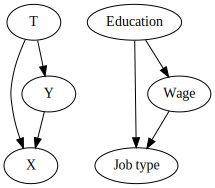

In [20]:
g = gr.Digraph()
g.edge("T", "X")
g.edge("T", "Y")
g.edge("Y", "X")
g.node("X", "X")

g.edge("Education", "Job type")
g.edge("Education", "Wage")
g.edge("Wage", "Job type")

g

#### Monte Carlo experiment with sample sizes N=100 and N=1000

In [21]:
class MCsimulator_3a():
    
    def __init__(self,n_rep):
        
        self.n_rep = n_rep
        
    def simulate_data(self,t,b,n):
        
        edu = np.sort(np.random.randint(1,6,n))
        job = np.sort(np.random.randint(1,4,n))
        wage = abs(np.random.normal(5,1,n)*(0.5*job) + np.random.normal(5,1,n)*(0.2*edu)).astype(int)
        df = pd.DataFrame(dict(edu = edu,
                              job = job,
                              wage = wage))
        
        return df
    
    def estimate_ols_params(self,df):
        
        mod = smf.ols('wage ~ edu + job', data=df)
        res = mod.fit()

        return res.params
    
    def run_mc_simulation(self,t,b,n):

        t_estimates = []
        for rep in range(self.n_rep):
            mod = self.simulate_data(t,b,n)
            a_hat, t_hat, b_hat = self.estimate_ols_params(df)
            t_estimates = t_estimates + [t_hat]
        return t_estimates
    
    def summarize_mc_simulation(self,t,b,n):
        t_estimates = self.run_mc_simulation(t,b,n)
        MSE = np.square(np.subtract(t,t_estimates)).mean() 
        RMSE = math.sqrt(MSE)
        
        print(f'Mean of treatment effect estimates={np.mean(t_estimates):.3f} \n')
        print(f'Bias = {np.mean(t_estimates)-(2.5):.3f} \n')
        print(f'Root Mean Square Error = {RMSE:.3f} \n')
        


In [22]:
mcSim_3a = MCsimulator_3a(100)
mcSim_3a.summarize_mc_simulation(2.5,3,100)

Mean of treatment effect estimates=1.111 

Bias = -1.389 

Root Mean Square Error = 1.389 



In [23]:
mcSim_3a = MCsimulator_3a(1000)
mcSim_3a.summarize_mc_simulation(2.5,3,1000)

Mean of treatment effect estimates=1.111 

Bias = -1.389 

Root Mean Square Error = 1.389 



In [24]:
class MCsimulator_3b():
    
    def __init__(self,n_rep):
        
        self.n_rep = n_rep
        
    def simulate_data(self,t,n):
        
        edu = np.sort(np.random.randint(1,6,n))
        job = np.sort(np.random.randint(1,4,n))
        wage = abs(np.random.normal(5,1,n)*(0.5*job) + np.random.normal(5,1,n)*(0.2*edu)).astype(int)
        df = pd.DataFrame(dict(edu = edu,
                              job = job,
                              wage = wage))
        
        return df
    
    def estimate_ols_params(self,df):
        
        mod = smf.ols('wage ~ edu', data=df)
        res = mod.fit()

        return res.params
    
    def run_mc_simulation(self,t,n):

        t_estimates = []
        for rep in range(self.n_rep):
            mod = self.simulate_data(t,n)
            a_hat, t_hat = self.estimate_ols_params(df)
            t_estimates = t_estimates + [t_hat]
        return t_estimates
    
    def summarize_mc_simulation(self,t,n):
        t_estimates = self.run_mc_simulation(t,n)
        MSE = np.square(np.subtract(t,t_estimates)).mean() 
        RMSE = math.sqrt(MSE)
        
        print(f'Mean of treatment effect estimates={np.mean(t_estimates):.3f} \n')
        print(f'Bias = {np.mean(t_estimates)-(2.5):.3f} \n')
        print(f'Root Mean Square Error = {RMSE:.3f} \n')


In [25]:
mcSim_3b = MCsimulator_3b(100)
mcSim_3b.summarize_mc_simulation(2.5,100)

Mean of treatment effect estimates=2.392 

Bias = -0.108 

Root Mean Square Error = 0.108 



In [26]:
mcSim_3b = MCsimulator_3b(1000)
mcSim_3b.summarize_mc_simulation(2.5,1000)

Mean of treatment effect estimates=2.392 

Bias = -0.108 

Root Mean Square Error = 0.108 

